# Modelo B para clasificación de imagenes

#### Jeffrey Daniel Leiva Cascante 2021016720
#### Richard Osvaldo León Chinchilla carnet

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchsummary import summary


In [2]:
from google.colab import drive
drive.mount('/content/drive')
torch.cuda.is_available()

Mounted at /content/drive


True

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Propuesta de modelo 1

Para la propuesta #1 del modelo B tenemos la siguiente arquitectura:

La primera capa es una capa de convolución de dos dimensiones que recibe la imágen de 1 canal (en escala de grises), aplica 64 filtros con tamaño de kernel 3 y padding de 1, lo que da como resultado la salida de 128x128x64.

La segunda capa aplica max pooling con un kernel de 2 y stride de 2, lo que produce una salida de 64x64x64.

Seguido de esto se tiene el módulo de Inception, que aplica varias operaciones de convolución y pooling en paralelo, lo que permite que el modelo aprenda mejor las características a diferentes niveles de complejidad. Cuenta con 4 ramas, en las que se aplican diversos tamaños de kernels y la salida de las ramas es de 64x64x128. Todas estas se concatenan y su salida es de 64x64x512.

Después se vuelve a aplicar max pooling con kernel de 2 y stride de 2, lo que da cómo resultado una salida de 32x32x512, se hace el flatten de la misma y esta es la entrada de la primera capa fully connected, la cual produce 128 canales de salida. La última capa tiene 128 canales de entrada y 3 de salida correspondientes a las tres categorías de imagenes.

Se utiliza reLU cómo función de activación para las capas convolucionales

In [11]:
class InceptionModuleOne(nn.Module):
  def __init__(self, chanels):
    super(InceptionModuleOne, self).__init__()

    self.branch1 = nn.Conv2d(chanels, 128, kernel_size=1)

    self.branch2 = nn.Sequential(
        nn.Conv2d(chanels, 128, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU()
    )

    self.branch3 = nn.Sequential(
        nn.Conv2d(chanels, 128, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=5, padding=2),
        nn.ReLU(),
    )

    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        nn.Conv2d(chanels, 128, kernel_size=1),
        nn.ReLU(),
    )

  def forward(self,x):
    branch1 = F.relu(self.branch1(x))
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch4 = self.branch4(x)
    return torch.cat([branch1, branch2, branch3, branch4],1)


class CNNModelBOne(nn.Module):
  def __init__(self):
    super(CNNModelBOne, self).__init__()
    self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.inception = InceptionModuleOne(64)
    self.dropout = nn.Dropout(0.2)
    self.fc1 = nn.Linear(512 *32 *32, 128)
    self.fc2 = nn.Linear(128 , 3)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = self.inception(x)
    x = self.pool(x)
    x = self.dropout(x)
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x



### Carga de datos y transformers de los datos

In [15]:
train_data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.RandomRotation(20),  # Rotación aleatoria
    transforms.RandomHorizontalFlip(),  # Inversión horizontal aleatoria
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Variación de brillo y contraste
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalización
])


test_data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.ToTensor(),   # Convertir a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalización
])


# Definir las rutas a las carpetas
train_dir = './drive/MyDrive/Covid19-dataset/train'
test_dir = './drive/MyDrive/Covid19-dataset/test'

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_data_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_data_transforms)

# Definir el tamaño del subconjunto que quieres usar
subset_size = 0.10  # Por ejemplo, usar el 20% de los datos

# Obtener los índices aleatorios para el subconjunto del conjunto de entrenamiento
np.random.seed(42)
train_size = len(train_dataset)
indices = list(range(train_size))
np.random.shuffle(indices)  # Mezclar los índices

subset_indices = indices[:int(subset_size * train_size)]  # Obtener el subconjunto

# Crear un SubsetRandomSampler con los índices seleccionados
train_sampler = SubsetRandomSampler(subset_indices)

# Obtener los índices aleatorios para el subconjunto del conjunto de testing
test_size = len(test_dataset)
indices_test = list(range(test_size))
np.random.shuffle(indices_test)  # Mezclar los índices

subset_indices_test = indices_test[:int(subset_size * test_size)]  # Obtener el subconjunto

# Crear un SubsetRandomSampler con los índices seleccionados
test_sampler = SubsetRandomSampler(subset_indices_test)

# Definir DataLoader para el conjunto de entrenamiento con el subconjunto de datos
train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler)

# También puedes crear un DataLoader para el conjunto de prueba completo
test_loader = DataLoader(test_dataset, batch_size=16, sampler=test_sampler)


### Proof of Concept Modelo 1

In [54]:

model = CNNModelBOne()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Definir la función de entrenamiento
def train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()  # Poner el modelo en modo de entrenamiento

        running_loss = 0.0
        correct = 0
        total = 0

        # Training
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Limpiar los gradientes
            outputs = model(inputs)  # Hacer una predicción
            loss = criterion(outputs, labels)  # Calcular la pérdida
            loss.backward()  # Hacer backpropagation
            optimizer.step()  # Actualizar los pesos

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():  # Disable gradients for validation
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_running_loss / len(test_loader)
        val_accuracy = 100 * val_correct / val_total

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Train the model with validation
train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=30)





Epoch 1/30, Train Loss: 1.1233, Train Accuracy: 20.00%, Val Loss: 1.0811, Val Accuracy: 33.33%
Epoch 2/30, Train Loss: 1.0853, Train Accuracy: 44.00%, Val Loss: 1.0685, Val Accuracy: 33.33%
Epoch 3/30, Train Loss: 1.0616, Train Accuracy: 28.00%, Val Loss: 1.0307, Val Accuracy: 50.00%
Epoch 4/30, Train Loss: 0.9814, Train Accuracy: 40.00%, Val Loss: 0.9923, Val Accuracy: 66.67%
Epoch 5/30, Train Loss: 0.9222, Train Accuracy: 80.00%, Val Loss: 0.9426, Val Accuracy: 66.67%
Epoch 6/30, Train Loss: 0.8676, Train Accuracy: 80.00%, Val Loss: 0.9380, Val Accuracy: 50.00%
Epoch 7/30, Train Loss: 0.8282, Train Accuracy: 68.00%, Val Loss: 0.9147, Val Accuracy: 50.00%
Epoch 8/30, Train Loss: 0.7246, Train Accuracy: 80.00%, Val Loss: 0.8684, Val Accuracy: 50.00%
Epoch 9/30, Train Loss: 0.7428, Train Accuracy: 72.00%, Val Loss: 0.8300, Val Accuracy: 50.00%
Epoch 10/30, Train Loss: 0.7414, Train Accuracy: 68.00%, Val Loss: 0.7652, Val Accuracy: 66.67%
Epoch 11/30, Train Loss: 0.6892, Train Accuracy: 

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
tensor([2, 1, 1, 2, 0, 0])


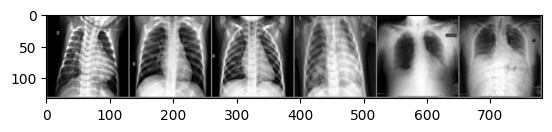

GroundTruth
Viral Pneumonia
Normal
Normal
Viral Pneumonia
Covid
Covid


In [18]:
classes = ('Covid', 'Normal','Viral Pneumonia')

#Para ver com se asignan las etiquetas a cada clase en el set de training
print(train_dataset.class_to_idx)
#Lo mismo pero para el set de testing
print(test_dataset.class_to_idx)

dataiter = iter(test_loader)
images, labels = next(dataiter)

print(labels)

def imshow(img):
    # Desnormalizar: (img * std) + mean
    img = img * 0.5 + 0.5  # Desnormalizar usando mean=0.5 y std=0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')  # Añadir cmap si es necesario
    plt.show()

imshow(torchvision.utils.make_grid(images))

print('GroundTruth')
for j in range(6):
    print(f'{classes[labels[j]]:5s}')

In [20]:
images = images.to(device)  # Mueve las imágenes a la GPU si está disponible

outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ')

for j in range(6):
    print(f'{classes[predicted[j]]:5s}')


Predicted: 
Viral Pneumonia
Normal
Viral Pneumonia
Viral Pneumonia
Normal
Covid


In [21]:
correct = 0
total = 0
# debido a que no estamos entrenando, no necesitamos calcular los gradientes para las salidas
with torch.no_grad():
    for data in test_loader:
        images, labels = images.to(device), labels.to(device)
        # calcular outputs corriendo imagenes en la red
        outputs = model(images)
        # La clase con mayor valor es la que escogemos como salida
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy de la red en las 23 imagenes de test: {100 * correct // total} %')

Accuracy de la red en las 23 imagenes de test: 66 %


## Propuesta de modelo 2

In [75]:
class InceptionModuleTwo(nn.Module):
  def __init__(self, chanels):
    super(InceptionModuleTwo, self).__init__()

    self.branch1 = nn.Conv2d(chanels, 128, kernel_size=1)

    self.branch2 = nn.Sequential(
        nn.Conv2d(chanels, 128, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU()
    )

    self.branch3 = nn.Sequential(
        nn.Conv2d(chanels, 128, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=5, padding=2),
        nn.ReLU(),
    )

    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        nn.Conv2d(chanels, 128, kernel_size=1),
        nn.ReLU(),
    )

  def forward(self,x):
    branch1 = F.relu(self.branch1(x))
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch4 = self.branch4(x)
    return torch.cat([branch1, branch2, branch3, branch4],1)


class CNNModelBTwo(nn.Module):
    def __init__(self):
        super(CNNModelBTwo, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.inception1 = InceptionModuleTwo(64)
        self.conv2 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.2)

        # Adjust this linear layer according to the final feature size after convolutions and pools
        self.fc1 = nn.Linear(2048 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 3)
        self.dropout2 = nn.Dropout(0.05)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.inception1(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.dropout1(x)
        x = torch.flatten(x, 1)


        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x






#### Proof of Concept modelo 2

In [74]:

model = CNNModelBTwo()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir la función de entrenamiento
def train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()  # Poner el modelo en modo de entrenamiento

        running_loss = 0.0
        correct = 0
        total = 0

        # Training
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Limpiar los gradientes
            outputs = model(inputs)  # Hacer una predicción
            loss = criterion(outputs, labels)  # Calcular la pérdida
            loss.backward()  # Hacer backpropagation
            optimizer.step()  # Actualizar los pesos

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():  # Disable gradients for validation
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_running_loss / len(test_loader)
        val_accuracy = 100 * val_correct / val_total

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Train the model with validation
train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=30)





OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 255.06 MiB is free. Process 198597 has 14.50 GiB memory in use. Of the allocated memory 12.30 GiB is allocated by PyTorch, and 2.06 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [76]:
torch.cuda.empty_cache()